# New York City taxi fair

## 1. Library とデータの読み込み

In [1]:
import os
import gc
import sys # Pythonのインタプリタや実行環境に関する情報を扱うためのライブラリ
import pandas as pd # データを扱うための標準的なライブラリ
import numpy as np # 多次元配列を扱う数値演算ライブラリ
import scipy as sp # 高度な科学計算を行うためのライブラリ
import sklearn # 機械学習のライブラリ

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor as RFR
import lightgbm as lgbm  #conda install -c conda-forge lightgbm
import xgboost as xgb    # conda install -c anaconda py-xgboost
from catboost import CatBoost
from catboost import Pool

import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

import matplotlib.pyplot as plt # グラフを描画するライブラリ
import seaborn as sns
%matplotlib inline 
# jupyter内に描画

# メモリ不足対応
# https://github.com/jupyterhub/jupyterhub/issues/713
#import pyspark
#import random
#memory = '8g'
#pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
#os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args
#sc = pyspark.SparkContext(appName="Pi")

In [2]:
df = pd.read_csv("./data/NYC_taxi_small.csv")
df.head()

key  fare_amount          pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3                1  
4                1

In [3]:
df.shape

(5000000, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 305.2+ MB


In [5]:
# 欠損値のカウント
df.isnull().apply(lambda col: col.value_counts(), axis=0).fillna(0).astype(np.int)

key  fare_amount  pickup_datetime  pickup_longitude  \
False  5000000      5000000          5000000           5000000   
True         0            0                0                 0   

       pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
False          5000000            4999964           4999964          5000000  
True                 0                 36                36                0

In [6]:
# 欠損値のカウント
df.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    36
dropoff_latitude     36
passenger_count       0
dtype: int64

In [7]:
# 欠損値を含む行を削除
df = df.dropna()
df.shape

(4999964, 8)

In [8]:
# 欠損値のカウント
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [9]:
# fair_amount の上限と下限
print("Minimum fair: ", min(df.fare_amount))
print("Maximun fair: ", max(df.fare_amount))

Minimum fair:  -100.0
Maximun fair:  1273.31


(array([3.589961e+06, 1.023984e+06, 2.130390e+05, 7.528400e+04,
        8.343700e+04, 6.560000e+03, 3.382000e+03, 1.691000e+03,
        8.090000e+02, 4.370000e+02, 3.670000e+02, 1.830000e+02,
        1.750000e+02, 1.070000e+02, 6.600000e+01, 5.600000e+01,
        5.900000e+01, 4.200000e+01, 2.300000e+01, 1.700000e+01,
        1.800000e+01, 1.000000e+01, 9.000000e+00, 6.000000e+00,
        4.000000e+00, 3.000000e+00, 2.000000e+00, 2.000000e+00,
        2.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 2.000000e+00, 1.000000e+00, 2.000000e+00,
        0.000000e+00, 3.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 3.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.00

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


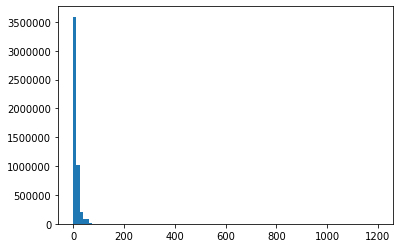

In [10]:
# fare_amount の棒グラフ --> 全領域
plt.hist(df.fare_amount, bins=100, range=(0, 1200))

(array([3.25420e+04, 1.45866e+05, 5.07530e+05, 4.91569e+05, 4.94902e+05,
        5.76507e+05, 3.93927e+05, 4.08547e+05, 2.68552e+05, 2.68844e+05,
        1.80494e+05, 1.78136e+05, 1.21336e+05, 1.21181e+05, 8.37000e+04,
        7.14740e+04, 7.15070e+04, 4.89950e+04, 4.90140e+04, 3.43950e+04,
        3.39070e+04, 2.57830e+04, 2.66520e+04, 2.17110e+04, 1.50350e+04,
        2.31480e+04, 1.78990e+04, 1.99540e+04, 1.71520e+04, 1.75100e+04,
        1.50610e+04, 1.44070e+04, 1.23250e+04, 1.04940e+04, 9.63900e+03,
        8.67800e+03, 8.47200e+03, 7.08500e+03, 6.78600e+03, 5.38800e+03,
        4.99100e+03, 4.07100e+03, 3.85200e+03, 1.62780e+04, 2.67800e+03,
        2.50200e+03, 2.09100e+03, 1.83000e+03, 3.06730e+04, 2.16700e+03,
        1.51300e+03, 1.06940e+04, 1.25000e+03, 1.12000e+03, 1.05300e+03,
        5.54400e+03, 2.55290e+04, 7.92000e+02, 6.94000e+02, 1.09800e+03,
        6.18000e+02, 6.39000e+02, 5.25000e+02, 5.27000e+02, 6.42000e+02,
        4.36000e+02, 4.15000e+02, 4.14000e+02, 3.80

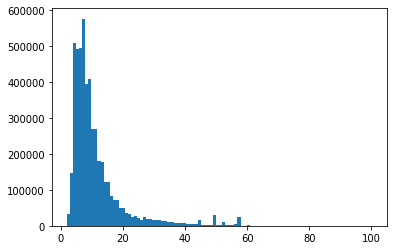

In [11]:
# fare_amount の棒グラフ 
plt.hist(df.fare_amount, bins=100, range=(2, 100))

In [12]:
# fare_amount がマイナスの行を削除
# df.drop(df.index[df.fare_amount <= 0], inplace=True)
# 初乗り料金は、2.5ドルなので fair_amount はそれ以上とする
df = df[(df['fare_amount'] >= 2.5)]
df.shape

(4999554, 8)

In [13]:
# fare_amount の最小値が2.5ドルになっていることを確認
print(min(df.fare_amount))

2.5


## 2. 関数の定義

In [14]:
# ２地点間の距離
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):

    # Define earth radius (km)
    R_earth = 6371
    # Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians, [pickup_lat, pickup_lon, dropoff_lat, dropoff_lon])
    # Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    # Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    
    return 2 * R_earth * np.arcsin(np.sqrt(a))

In [15]:
# pickup地点とdroppff地点から、経度・緯度の差と2地点間の距離をdfに追加
def add_coordinate_features(df):
    
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    # Add new features
    #df['latdiff'] = (lat1 - lat2)
    #df['londiff'] = (lon1 - lon2)
    df['distance'] = sphere_dist(lat1, lon1, lat2, lon2)

    return

In [16]:
# 空港からの距離をdfに追加
def add_airport_dist(df):
    
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    SOL: Statue of Liberty 
    NYC: Newyork Central
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    sol_coord = (40.6892,-74.0445) # Statue of Liberty
    nyc_coord = (40.7141667,-74.0063889) 
    
    pickup_lat = df['pickup_latitude']
    dropoff_lat = df['dropoff_latitude']
    pickup_lon = df['pickup_longitude']
    dropoff_lon = df['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon)
    pickup_sol = sphere_dist(pickup_lat, pickup_lon, sol_coord[0], sol_coord[1]) 
    dropoff_sol = sphere_dist(sol_coord[0], sol_coord[1], dropoff_lat, dropoff_lon)
    pickup_nyc = sphere_dist(pickup_lat, pickup_lon, nyc_coord[0], nyc_coord[1]) 
    dropoff_nyc = sphere_dist(nyc_coord[0], nyc_coord[1], dropoff_lat, dropoff_lon)
    
    df['jfk_dist'] = pickup_jfk + dropoff_jfk
    df['ewr_dist'] = pickup_ewr + dropoff_ewr
    df['lga_dist'] = pickup_lga + dropoff_lga
    df['sol_dist'] = pickup_sol + dropoff_sol
    df['nyc_dist'] = pickup_nyc + dropoff_nyc
    
    return

In [2]:
# 回帰結果評価用関数
def Regression_evaluator(y_test, y_pred):
    
    # 平均絶対誤差 (MAE: Mean Absolute Error)
    print("平均絶対誤差：", mean_absolute_error(y_test, y_pred))
    # 平均二乗誤差 (MSE: Mean Squared Error)
    print("平均絶対誤差：", mean_squared_error(y_test, y_pred))
    # 二乗平均平方根誤差 (RMSE: Root Mean Squared Error) -- sklearn には実装されていないのでnumpyを利用
    print("二乗平均平方根誤差：", np.sqrt(mean_squared_error(y_test, y_pred)))
    # 相関係数（Correlation)
    print("相関係数 (R)：", np.sqrt(r2_score(y_test, y_pred)))
    # 決定係数 (R2, R-squared, coefficient of determination)) 
    print("決定係数 (R2)：", r2_score(y_test, y_pred))
    
    return

In [3]:
# 散布図描画関数
def Draw_scatter(y_test, y_pred):
    
    fig = plt.figure(figsize=(10,10))
    plt.scatter(y_test, y_pred, s=0.5)
    plt.scatter(y_test, y_test, s=0.5)
    #plt.title('Linear regression')
    plt.xlabel('Real values')
    plt.ylabel('Predicted values')
    plt.grid()
    plt.show()
    
    return

In [4]:
# 散布図描画関数(2)
def Draw_scatter2(y_test, y_pred):
    
    fig = plt.figure(figsize=(10,10))
    plt.scatter(y_test, y_pred, s=0.5)
    plt.scatter(y_test, y_test, s=0.5)
    plt.xlim(-10, 100)
    plt.ylim(-10, 100)
    #plt.title('Linear regression')
    plt.xlabel('Real values')
    plt.ylabel('Predicted values')
    plt.grid()
    plt.show()
    
    return

## 3. 特徴量の作成

In [20]:
# pickup地点とdroppff地点間の距離をdfに追加
add_coordinate_features(df)

In [22]:
# 空港からの距離をdfに追加
add_airport_dist(df)

In [21]:
# datetimeを分離するしてdfに追加 --> 時間がかかる
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_datetime_month'] = df['pickup_datetime'].dt.month
df['pickup_datetime_year'] = df['pickup_datetime'].dt.year
df['pickup_datetime_day_of_week'] = df['pickup_datetime'].dt.weekday
df['pickup_datetime_day_of_hour'] = df['pickup_datetime'].dt.hour

In [23]:
# 最短および最長距離
print("Minimum distance:", min(df.distance))
print("Maximum distance:", max(df.distance))

Minimum distance: 0.0
Maximum distance: 19108.803538123844


(array([0.000000e+00, 3.354800e+05, 1.091113e+06, 1.026908e+06,
        7.382170e+05, 5.772990e+05, 2.997290e+05, 2.049740e+05,
        1.526720e+05, 9.473400e+04, 7.525700e+04, 5.065800e+04,
        4.321900e+04, 4.284200e+04, 3.560200e+04, 3.119500e+04,
        2.375200e+04, 1.971200e+04, 1.566600e+04, 1.088600e+04,
        8.839000e+03, 1.939200e+04, 4.649000e+03, 3.275000e+04,
        1.328500e+04, 2.754000e+03, 1.971000e+03, 3.114000e+04,
        1.898000e+03, 1.237000e+03, 1.413000e+03, 8.900000e+02,
        8.540000e+02, 8.890000e+02, 6.620000e+02, 7.280000e+02,
        5.250000e+02, 5.730000e+02, 6.880000e+02, 3.960000e+02,
        5.050000e+02, 3.110000e+02, 3.860000e+02, 1.900000e+02,
        1.640000e+02, 1.970000e+02, 1.280000e+02, 2.900000e+02,
        9.600000e+01, 1.030000e+02, 1.130000e+02, 6.400000e+01,
        1.310000e+02, 7.900000e+01, 7.600000e+01, 5.000000e+01,
        5.000000e+01, 1.430000e+02, 3.500000e+01, 6.000000e+01,
        4.100000e+01, 6.900000e+01, 3.20

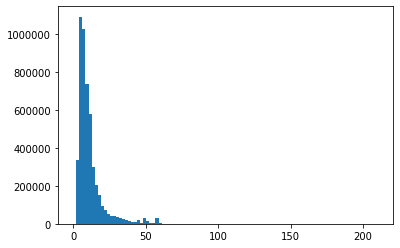

In [24]:
# distance の棒グラフ --> 全領域
plt.hist(df.fare_amount, bins=100, range=(0, 210))

(array([1.8710e+03, 1.6840e+03, 8.2800e+02, 6.8500e+02, 1.0085e+04,
        6.1100e+02, 7.9000e+02, 4.6000e+02, 5.3000e+02, 5.9200e+02,
        7.0700e+02, 3.9000e+02, 4.2200e+02, 5.1200e+03, 2.2104e+04,
        3.4080e+03, 4.8600e+02, 3.2200e+02, 3.0300e+02, 4.3100e+02,
        8.3700e+02, 2.5500e+02, 3.2900e+02, 3.3800e+02, 2.7900e+02,
        2.8600e+02, 3.0500e+02, 2.8500e+02, 2.3400e+02, 2.5200e+02,
        4.4000e+02, 2.5700e+02, 2.2500e+02, 1.8800e+02, 2.0200e+02,
        1.9800e+02, 2.2200e+02, 2.0200e+02, 1.9000e+02, 1.7200e+02,
        3.7100e+02, 1.4200e+02, 1.7700e+02, 1.7400e+02, 1.5400e+02,
        1.4700e+02, 1.7100e+02, 1.3500e+02, 1.4300e+02, 1.1800e+02,
        2.9200e+02, 9.7000e+01, 1.5700e+02, 1.3600e+02, 1.1800e+02,
        1.2700e+02, 1.5600e+02, 1.1600e+02, 1.2900e+02, 1.2600e+02,
        3.6500e+02, 7.6000e+01, 1.2800e+02, 1.0100e+02, 1.1200e+02,
        8.9000e+01, 1.0300e+02, 8.6000e+01, 9.0000e+01, 1.0800e+02,
        1.8600e+02, 7.0000e+01, 8.9000e+01, 5.60

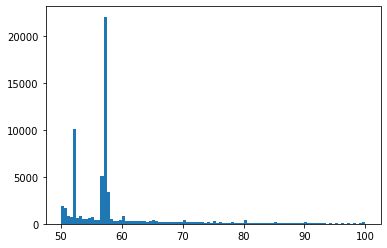

In [25]:
# distance の棒グラフ --> 50-100km
plt.hist(df.fare_amount, bins=100, range=(50, 100))

(array([211.,  52.,  43.,  52.,  51.,  65.,  36.,  29.,  38.,  33.,  82.,
         42.,  42.,  32.,  32.,  39.,  28.,  17.,  23.,  29., 122.,  18.,
         16.,  18.,  12.,  48.,  16.,  15.,  22.,  19.,  43.,  18.,  18.,
         17.,  13.,  32.,  19.,   7.,   6.,  11.,  41.,   6.,   5.,   8.,
         13.,  23.,   4.,  10.,  13.,  11.,  55.,   5.,  11.,   3.,   7.,
         20.,  12.,  10.,   5.,  10.,  32.,   6.,   3.,   4.,   5.,   8.,
          8.,   4.,   3.,   5.,  14.,   4.,   8.,   3.,   5.,  13.,   5.,
          1.,   3.,   2.,  22.,   2.,   1.,   1.,   2.,   9.,   2.,   4.,
          0.,   4.,   5.,   4.,   2.,   1.,   1.,   6.,   2.,   1.,   3.,
         34.]),
 array([100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
        111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
        122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
        133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
        144., 145., 14

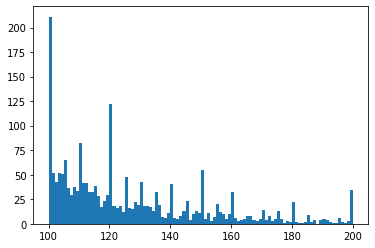

In [26]:
# distance の棒グラフ --> 100-200km
plt.hist(df.fare_amount, bins=100, range=(100, 200))

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.05330e+04, 1.00000e+00, 1.10000e+01, 0.00000e+00, 2.00000e+00,
        2.00000e+00, 1.00000e+00, 1.19810e+04, 6.00000e+00, 0.00000e+00,
        9.01300e+03, 1.00000e+00, 1.00000e+00, 0.00000e+00, 3.00000e+00,
        3.72590e+04, 1.00000e+00, 1.93000e+02, 0.00

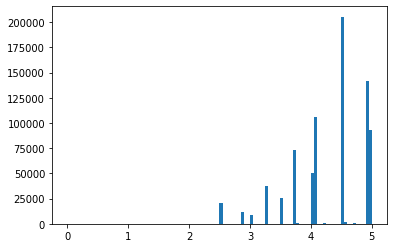

In [27]:
# distance の棒グラフ --> 近距離
plt.hist(df.fare_amount, bins=100, range=(0, 5))

In [28]:
# distance 下限を設定(100m)
df = df[(df.distance > 0.1)]

In [29]:
# 最短および最長距離
print("Minimum distance:", min(df.distance))
print("Maximum distance:", max(df.distance))

Minimum distance: 0.1000056875415409
Maximum distance: 19108.803538123844


In [30]:
df.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  distance  pickup_datetime_month  pickup_datetime_year  \
0                1  1.030764                      6                  2009   
1                1  8.450134                      1                  2010   
2                2  1.389525                      8                  2011   
3                1  2.799270                      4                  2012   
4                1  1.999157                      3                  2010   

   pickup_datetime_day_of_week  pickup_datetime_day_of_hour   jfk_dist  \
0                            0                           17  20.265840   
1                            1                           16  44.667679   
2                            3                            0  43.597686   
3                            5                            4  42.642965   
4                            1                            7  43.329953   

    ewr_dist   lga_dist   sol_dist   nyc_dist  
0  55.176046  14.342611  34.543548  27.572573  
1  31.832358  23.130775  15.125872   8.755732  
2  33.712082  19.865289  17.722624   9.847344  
3  32.556289  21.063132  15.738963   7.703421  
4  39.406828  15.219339  23.732406  15.600745

In [31]:
df.shape

(4827884, 18)

In [32]:
# 特徴量設定後の df を保存
# df.to_csv("./data/df_treated.csv",index=False)

In [7]:
# CSVファイルの読み込み
# df = pd.read_csv("./data/df_treated.csv")

## 4. 学習用・検証用データセット作成

In [33]:
# 運賃と乗客数の相関
correlation = np.corrcoef(df['fare_amount'], df['passenger_count'])
print(correlation)
# 乗客数の寄与は非常に小さいので目的変数から外す

[[1.         0.01613232]
 [0.01613232 1.        ]]


In [34]:
# 説明変数と目的変数の分離
X = pd.DataFrame(df.drop(["fare_amount","key","pickup_datetime","passenger_count"], axis=1)) 
y = pd.DataFrame(df.fare_amount)

In [35]:
# 学習用・検証用データセット作成
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

In [ ]:
# 説明変数の標準化は、この問題では有効ではなかった。

In [5]:
# 説明変数（X)のデータ標準化
#X_col = X.columns
#X_std = StandardScaler().fit_transform(X)
#X_std = pd.DataFrame(X_std, index=df.index, columns=X_col)

In [ ]:
#X_std.head()

In [7]:
# 学習用・検証用データセット作成
#X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.05, random_state=0)

## 5. 学習と検証

### 5-1. Random Forest

In [36]:
# ランダムフォレスト
gc.collect() #gc.collect()は回収可能なオブジェクトを削除する

model = RFR(n_jobs=-1, random_state=2525) 

# モデルの学習
model = model.fit(X_train, y_train)

gc.collect()

C:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Seminar\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Seminar\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



6

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


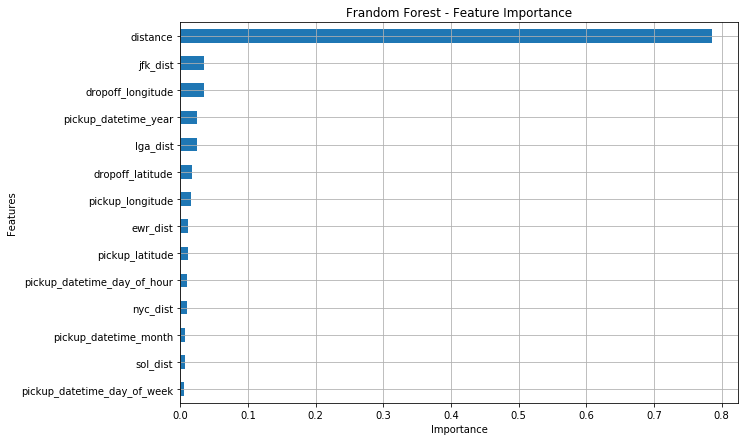

In [37]:
# 説明変数の重要度のグラフ化
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Frandom Forest - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.grid()
plt.show()

In [38]:
y_pred = model.predict(X_test)

In [39]:
Regression_evaluator(y_test, y_pred) # 関数呼び出し

平均絶対誤差： 1.6199304790902882
平均絶対誤差： 11.367633037560845
二乗平均平方根誤差： 3.371592062744371
相関係数 (R)： 0.9352176213215625
決定係数 (R2)： 0.8746319992303614


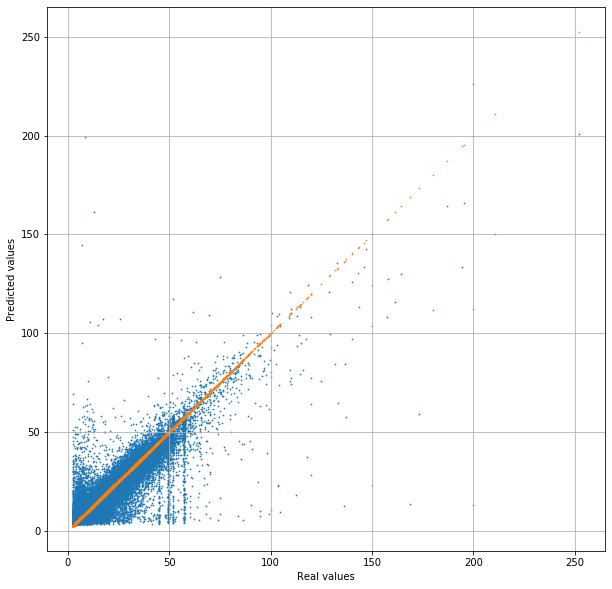

In [40]:
Draw_scatter(y_test, y_pred) # 関数呼び出し

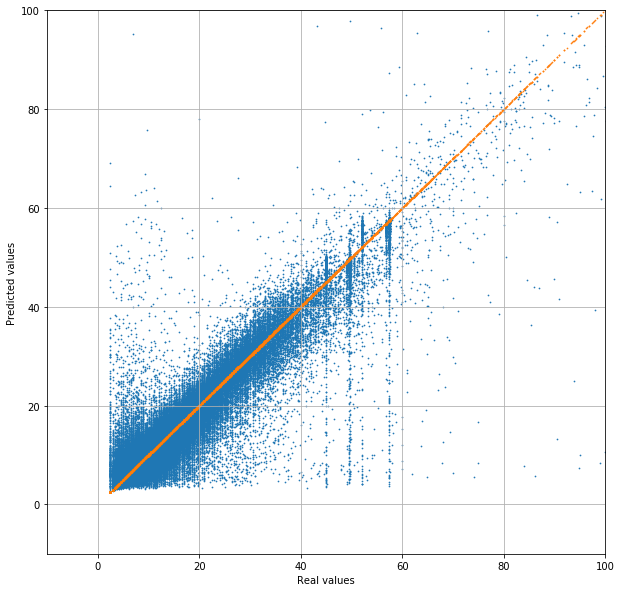

In [41]:
Draw_scatter2(y_test, y_pred) # 関数呼び出し

### 5-2. LightBGM

In [42]:
lgbm.LGBMRegressor()

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [43]:
# https://www.kaggle.com/namakaho/nyctaxi
# https://www.kaggle.com/jsylas/top-ten-rank-r-22m-rows-2-90-lightgbm

params = {'boosting_type':'gbdt',
          'objective': 'regression',
          'nthread': 4,
          'num_leaves': 31,
          'learning_rate': 0.034,
          'max_depth': -1,
          'subsample': 0.8,
          'bagging_fraction' : 1,
          'max_bin' : 5000 ,
          'bagging_freq': 20,
          'colsample_bytree': 0.6,
          'metric': 'rmse',      # rmse: root meam square error
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight':1,
          'zero_as_missing': True,
          'seed':128, # 0 から変更
          'num_rounds':50000}

In [44]:
gc.collect()

train_set = lgbm.Dataset(X_train, y_train, silent=False)
valid_set = lgbm.Dataset(X_test, y_test, silent=False)
model = lgbm.train(params, train_set = train_set, num_boost_round=500,early_stopping_rounds=500,
                   verbose_eval=500, valid_sets=valid_set)

gc.collect()

C:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Seminar\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 3.2776
[1000]	valid_0's rmse: 3.20741
[1500]	valid_0's rmse: 3.16926
[2000]	valid_0's rmse: 3.148
[2500]	valid_0's rmse: 3.13299
[3000]	valid_0's rmse: 3.12282
[3500]	valid_0's rmse: 3.11525
[4000]	valid_0's rmse: 3.10719
[4500]	valid_0's rmse: 3.10288
[5000]	valid_0's rmse: 3.09986
[5500]	valid_0's rmse: 3.09831
[6000]	valid_0's rmse: 3.09588
[6500]	valid_0's rmse: 3.09319
[7000]	valid_0's rmse: 3.0907
[7500]	valid_0's rmse: 3.08931
[8000]	valid_0's rmse: 3.08824
[8500]	valid_0's rmse: 3.08682
[9000]	valid_0's rmse: 3.08468
[9500]	valid_0's rmse: 3.08385
[10000]	valid_0's rmse: 3.08277
[10500]	valid_0's rmse: 3.08158
[11000]	valid_0's rmse: 3.08095
[11500]	valid_0's rmse: 3.08023
[12000]	valid_0's rmse: 3.07949
[12500]	valid_0's rmse: 3.07863
[13000]	valid_0's rmse: 3.07805
[13500]	valid_0's rmse: 3.07748
[14000]	valid_0's rmse: 3.07693
[14500]	valid_0's rmse: 3.07631
[15000]	valid_0's rmse: 3.07568
[1

17

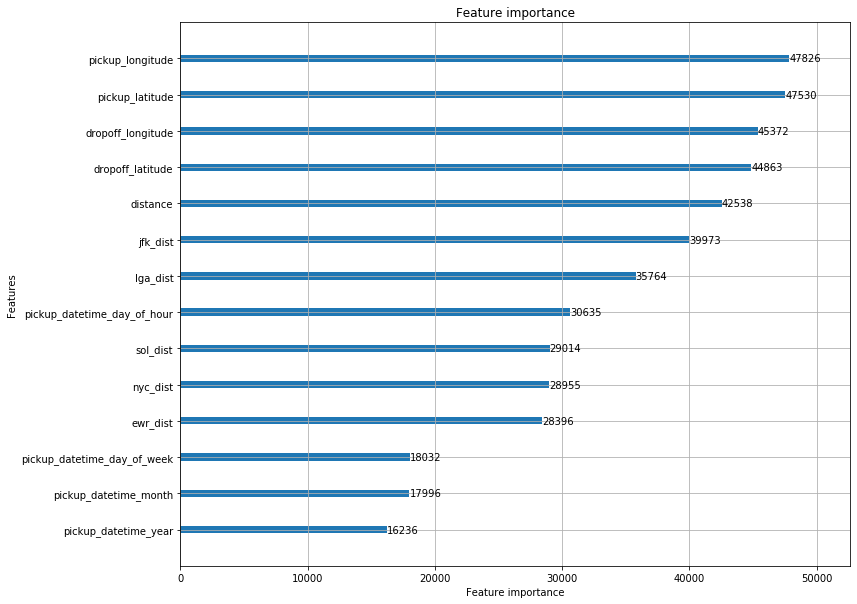

In [45]:
lgbm.plot_importance(model, figsize=(12, 10))

In [47]:
y_pred = model.predict(X_test)

In [48]:
Regression_evaluator(y_test, y_pred) # 関数呼び出し

平均絶対誤差： 1.4314319999533185
平均絶対誤差： 9.453780004160146
二乗平均平方根誤差： 3.074699986040938
相関係数 (R)： 0.9464348564373823
決定係数 (R2)： 0.8957389374796485


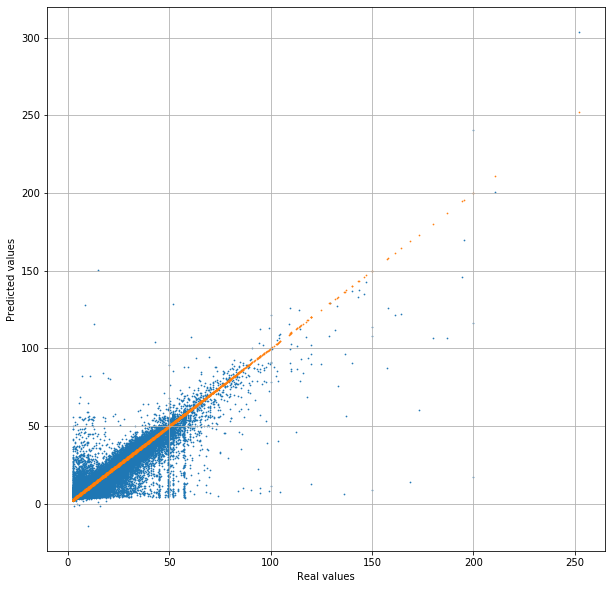

In [49]:
Draw_scatter(y_test, y_pred) # 関数呼び出し

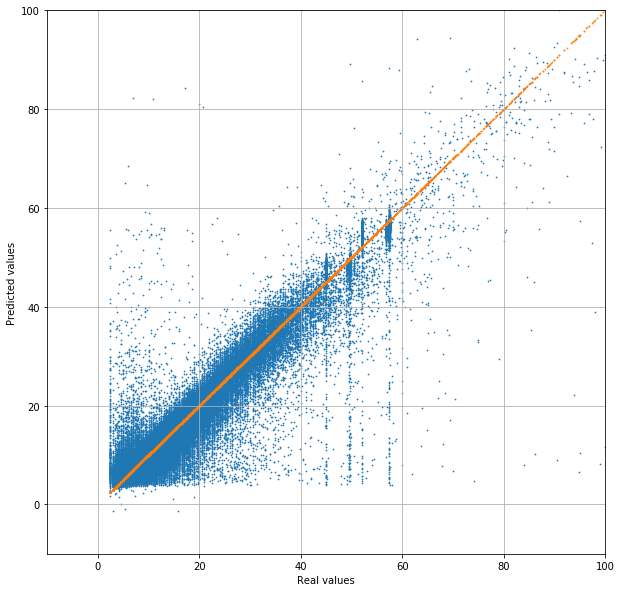

In [50]:
Draw_scatter2(y_test, y_pred) # 関数呼び出し

In [51]:
# lightBGM(2) --> (1) より時間がかかる
# https://towardsdatascience.com/ad-demand-forecast-with-catboost-lightgbm-819e5073cd3e

gc.collect()

# LightGBM dataset formatting 
train_set = lgbm.Dataset(X_train, y_train, silent=False)
valid_set = lgbm.Dataset(X_test, y_test, silent=False)

params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 200,
    'max_depth': 15,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.6,
    'verbosity' : -1,
    'num_rounds':50000 # 追加
}

train_set = lgbm.Dataset(X_train, y_train, silent=False)
valid_set = lgbm.Dataset(X_test, y_test, silent=False)
model = lgbm.train(params, train_set = train_set, num_boost_round=500,early_stopping_rounds=500,
                   verbose_eval=500, valid_sets=valid_set)

gc.collect()

C:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Seminar\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 3.29992
[1000]	valid_0's rmse: 3.20915
[1500]	valid_0's rmse: 3.17037
[2000]	valid_0's rmse: 3.14895
[2500]	valid_0's rmse: 3.13612
[3000]	valid_0's rmse: 3.12948
[3500]	valid_0's rmse: 3.12425
[4000]	valid_0's rmse: 3.1193
[4500]	valid_0's rmse: 3.11472
[5000]	valid_0's rmse: 3.11099
[5500]	valid_0's rmse: 3.10867
[6000]	valid_0's rmse: 3.10609
[6500]	valid_0's rmse: 3.10444
[7000]	valid_0's rmse: 3.10291
[7500]	valid_0's rmse: 3.10228
[8000]	valid_0's rmse: 3.10075
[8500]	valid_0's rmse: 3.09956
[9000]	valid_0's rmse: 3.09917
[9500]	valid_0's rmse: 3.09887
[10000]	valid_0's rmse: 3.09859
[10500]	valid_0's rmse: 3.09825
[11000]	valid_0's rmse: 3.09799
[11500]	valid_0's rmse: 3.09779
[12000]	valid_0's rmse: 3.09737
[12500]	valid_0's rmse: 3.09716
[13000]	valid_0's rmse: 3.09758
Early stopping, best iteration is:
[12557]	valid_0's rmse: 3.09708


528

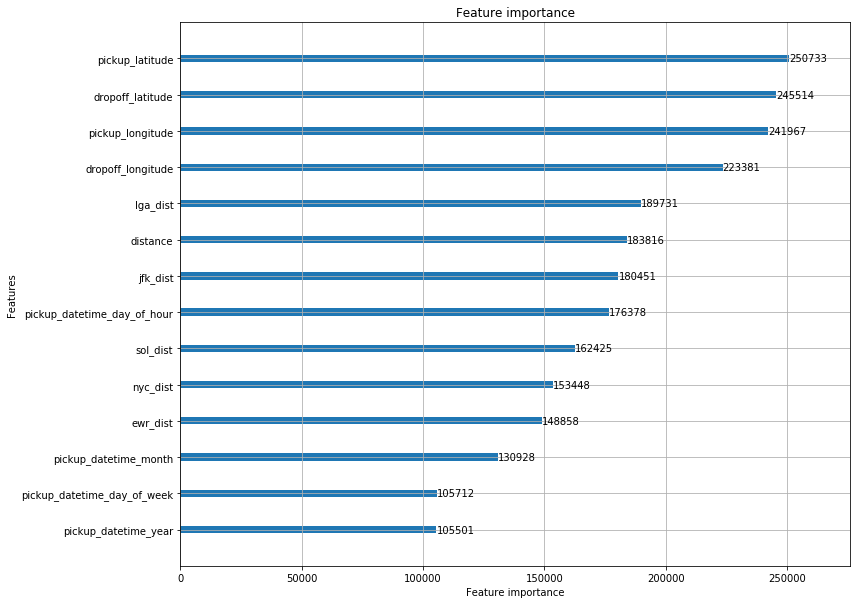

In [52]:
lgbm.plot_importance(model, figsize=(12, 10))

In [53]:
Regression_evaluator(y_test, y_pred) # 関数呼び出し

平均絶対誤差： 1.4314319999533185
平均絶対誤差： 9.453780004160146
二乗平均平方根誤差： 3.074699986040938
相関係数 (R)： 0.9464348564373823
決定係数 (R2)： 0.8957389374796485


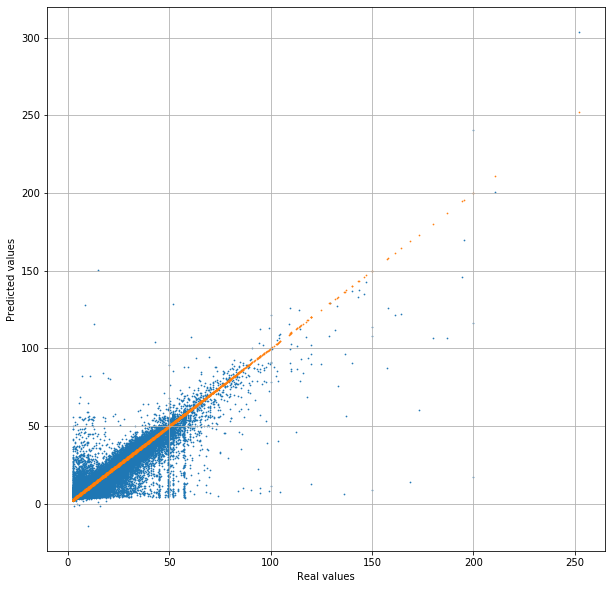

In [54]:
Draw_scatter(y_test, y_pred) # 関数呼び出し

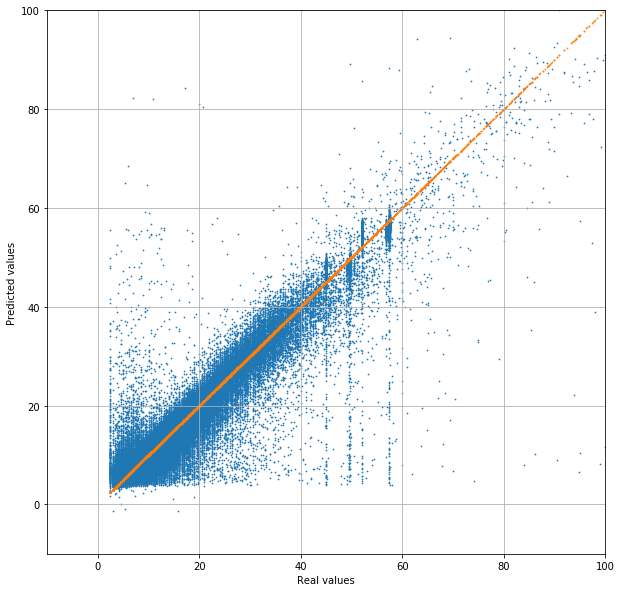

In [55]:
Draw_scatter2(y_test, y_pred) # 関数呼び出し

### 5-3. Catboost

In [56]:
# Catboost(1)
# https://blog.amedama.jp/entry/catboost

gc.collect()

train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

params = {'loss_function': 'RMSE', # 損失関数に RMSE を使う
         'num_boost_round': 1000,
         'early_stopping_rounds': 10}

model = CatBoost(params)
model.fit(train_pool, eval_set=[test_pool], plot=True)

gc.collect()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 9.3011880	test: 9.3059463	best: 9.3059463 (0)	total: 598ms	remaining: 9m 57s
1:	learn: 9.0928406	test: 9.0962258	best: 9.0962258 (1)	total: 1.2s	remaining: 9m 56s
2:	learn: 8.8929349	test: 8.8958638	best: 8.8958638 (2)	total: 1.77s	remaining: 9m 47s
3:	learn: 8.6994442	test: 8.7017054	best: 8.7017054 (3)	total: 2.34s	remaining: 9m 43s
4:	learn: 8.5096985	test: 8.5108166	best: 8.5108166 (4)	total: 2.89s	remaining: 9m 35s
5:	learn: 8.3292198	test: 8.3291066	best: 8.3291066 (5)	total: 3.46s	remaining: 9m 33s
6:	learn: 8.1524801	test: 8.1514394	best: 8.1514394 (6)	total: 4.01s	remaining: 9m 29s
7:	learn: 7.9817890	test: 7.9797993	best: 7.9797993 (7)	total: 4.57s	remaining: 9m 26s
8:	learn: 7.8178633	test: 7.8149407	best: 7.8149407 (8)	total: 5.11s	remaining: 9m 22s
9:	learn: 7.6628694	test: 7.6592699	best: 7.6592699 (9)	total: 5.67s	remaining: 9m 20s
10:	learn: 7.5112957	test: 7.5068012	best: 7.5068012 (10)	total: 6.2s	remaining: 9m 17s
11:	learn: 7.3631009	test: 7.3576785	best: 

93:	learn: 3.8964496	test: 3.8728344	best: 3.8728344 (93)	total: 54.2s	remaining: 8m 42s
94:	learn: 3.8911329	test: 3.8675232	best: 3.8675232 (94)	total: 54.8s	remaining: 8m 42s
95:	learn: 3.8847432	test: 3.8609207	best: 3.8609207 (95)	total: 55.3s	remaining: 8m 40s
96:	learn: 3.8796985	test: 3.8558918	best: 3.8558918 (96)	total: 55.9s	remaining: 8m 40s
97:	learn: 3.8750644	test: 3.8511649	best: 3.8511649 (97)	total: 56.5s	remaining: 8m 40s
98:	learn: 3.8704759	test: 3.8466371	best: 3.8466371 (98)	total: 57.1s	remaining: 8m 39s
99:	learn: 3.8644493	test: 3.8408103	best: 3.8408103 (99)	total: 57.7s	remaining: 8m 38s
100:	learn: 3.8600845	test: 3.8364828	best: 3.8364828 (100)	total: 58.2s	remaining: 8m 38s
101:	learn: 3.8560318	test: 3.8324256	best: 3.8324256 (101)	total: 58.8s	remaining: 8m 37s
102:	learn: 3.8516590	test: 3.8281013	best: 3.8281013 (102)	total: 59.4s	remaining: 8m 37s
103:	learn: 3.8470387	test: 3.8237013	best: 3.8237013 (103)	total: 60s	remaining: 8m 36s
104:	learn: 3.8

183:	learn: 3.6432286	test: 3.6227339	best: 3.6227339 (183)	total: 1m 45s	remaining: 7m 48s
184:	learn: 3.6423649	test: 3.6218529	best: 3.6218529 (184)	total: 1m 46s	remaining: 7m 48s
185:	learn: 3.6410703	test: 3.6205881	best: 3.6205881 (185)	total: 1m 46s	remaining: 7m 48s
186:	learn: 3.6390841	test: 3.6190574	best: 3.6190574 (186)	total: 1m 47s	remaining: 7m 47s
187:	learn: 3.6379850	test: 3.6179368	best: 3.6179368 (187)	total: 1m 48s	remaining: 7m 47s
188:	learn: 3.6366101	test: 3.6163847	best: 3.6163847 (188)	total: 1m 48s	remaining: 7m 46s
189:	learn: 3.6354019	test: 3.6151377	best: 3.6151377 (189)	total: 1m 49s	remaining: 7m 45s
190:	learn: 3.6340015	test: 3.6139241	best: 3.6139241 (190)	total: 1m 49s	remaining: 7m 45s
191:	learn: 3.6331397	test: 3.6130389	best: 3.6130389 (191)	total: 1m 50s	remaining: 7m 44s
192:	learn: 3.6307199	test: 3.6112060	best: 3.6112060 (192)	total: 1m 51s	remaining: 7m 44s
193:	learn: 3.6299313	test: 3.6104106	best: 3.6104106 (193)	total: 1m 51s	remain

273:	learn: 3.5559871	test: 3.5355373	best: 3.5355373 (273)	total: 2m 37s	remaining: 6m 57s
274:	learn: 3.5554312	test: 3.5349512	best: 3.5349512 (274)	total: 2m 38s	remaining: 6m 56s
275:	learn: 3.5547088	test: 3.5341826	best: 3.5341826 (275)	total: 2m 38s	remaining: 6m 56s
276:	learn: 3.5542513	test: 3.5337996	best: 3.5337996 (276)	total: 2m 39s	remaining: 6m 55s
277:	learn: 3.5530609	test: 3.5327404	best: 3.5327404 (277)	total: 2m 39s	remaining: 6m 55s
278:	learn: 3.5524716	test: 3.5321111	best: 3.5321111 (278)	total: 2m 40s	remaining: 6m 54s
279:	learn: 3.5510278	test: 3.5309216	best: 3.5309216 (279)	total: 2m 41s	remaining: 6m 54s
280:	learn: 3.5504803	test: 3.5302958	best: 3.5302958 (280)	total: 2m 41s	remaining: 6m 53s
281:	learn: 3.5501301	test: 3.5299138	best: 3.5299138 (281)	total: 2m 42s	remaining: 6m 52s
282:	learn: 3.5490102	test: 3.5289747	best: 3.5289747 (282)	total: 2m 42s	remaining: 6m 52s
283:	learn: 3.5482935	test: 3.5282132	best: 3.5282132 (283)	total: 2m 43s	remain

363:	learn: 3.5004836	test: 3.4826410	best: 3.4826410 (363)	total: 3m 29s	remaining: 6m 5s
364:	learn: 3.5002530	test: 3.4824148	best: 3.4824148 (364)	total: 3m 29s	remaining: 6m 4s
365:	learn: 3.4996321	test: 3.4820122	best: 3.4820122 (365)	total: 3m 30s	remaining: 6m 3s
366:	learn: 3.4987271	test: 3.4811449	best: 3.4811449 (366)	total: 3m 30s	remaining: 6m 3s
367:	learn: 3.4980122	test: 3.4804116	best: 3.4804116 (367)	total: 3m 31s	remaining: 6m 2s
368:	learn: 3.4977814	test: 3.4801783	best: 3.4801783 (368)	total: 3m 31s	remaining: 6m 2s
369:	learn: 3.4975077	test: 3.4800431	best: 3.4800431 (369)	total: 3m 32s	remaining: 6m 1s
370:	learn: 3.4971800	test: 3.4797152	best: 3.4797152 (370)	total: 3m 32s	remaining: 6m
371:	learn: 3.4965579	test: 3.4793645	best: 3.4793645 (371)	total: 3m 33s	remaining: 6m
372:	learn: 3.4960700	test: 3.4788866	best: 3.4788866 (372)	total: 3m 33s	remaining: 5m 59s
373:	learn: 3.4955044	test: 3.4785560	best: 3.4785560 (373)	total: 3m 34s	remaining: 5m 59s
374

453:	learn: 3.4625021	test: 3.4487346	best: 3.4487346 (453)	total: 4m 20s	remaining: 5m 13s
454:	learn: 3.4621397	test: 3.4483333	best: 3.4483333 (454)	total: 4m 21s	remaining: 5m 13s
455:	learn: 3.4617716	test: 3.4480251	best: 3.4480251 (455)	total: 4m 22s	remaining: 5m 12s
456:	learn: 3.4612909	test: 3.4475468	best: 3.4475468 (456)	total: 4m 22s	remaining: 5m 12s
457:	learn: 3.4611138	test: 3.4473738	best: 3.4473738 (457)	total: 4m 23s	remaining: 5m 11s
458:	learn: 3.4608788	test: 3.4470744	best: 3.4470744 (458)	total: 4m 23s	remaining: 5m 10s
459:	learn: 3.4606636	test: 3.4468541	best: 3.4468541 (459)	total: 4m 24s	remaining: 5m 10s
460:	learn: 3.4604384	test: 3.4466273	best: 3.4466273 (460)	total: 4m 25s	remaining: 5m 9s
461:	learn: 3.4600983	test: 3.4462714	best: 3.4462714 (461)	total: 4m 25s	remaining: 5m 9s
462:	learn: 3.4597003	test: 3.4459971	best: 3.4459971 (462)	total: 4m 26s	remaining: 5m 8s
463:	learn: 3.4591259	test: 3.4454441	best: 3.4454441 (463)	total: 4m 26s	remaining

543:	learn: 3.4322679	test: 3.4227203	best: 3.4227203 (543)	total: 5m 12s	remaining: 4m 21s
544:	learn: 3.4320031	test: 3.4224106	best: 3.4224106 (544)	total: 5m 12s	remaining: 4m 21s
545:	learn: 3.4316169	test: 3.4222510	best: 3.4222510 (545)	total: 5m 13s	remaining: 4m 20s
546:	learn: 3.4314376	test: 3.4220685	best: 3.4220685 (546)	total: 5m 13s	remaining: 4m 20s
547:	learn: 3.4310616	test: 3.4217614	best: 3.4217614 (547)	total: 5m 14s	remaining: 4m 19s
548:	learn: 3.4309072	test: 3.4216150	best: 3.4216150 (548)	total: 5m 15s	remaining: 4m 18s
549:	learn: 3.4305245	test: 3.4212790	best: 3.4212790 (549)	total: 5m 15s	remaining: 4m 18s
550:	learn: 3.4302613	test: 3.4211029	best: 3.4211029 (550)	total: 5m 16s	remaining: 4m 17s
551:	learn: 3.4301467	test: 3.4209826	best: 3.4209826 (551)	total: 5m 16s	remaining: 4m 17s
552:	learn: 3.4296390	test: 3.4205149	best: 3.4205149 (552)	total: 5m 17s	remaining: 4m 16s
553:	learn: 3.4293553	test: 3.4203467	best: 3.4203467 (553)	total: 5m 17s	remain

633:	learn: 3.4085868	test: 3.4024139	best: 3.4024139 (633)	total: 6m 10s	remaining: 3m 33s
634:	learn: 3.4084894	test: 3.4024167	best: 3.4024139 (633)	total: 6m 11s	remaining: 3m 33s
635:	learn: 3.4082191	test: 3.4022923	best: 3.4022923 (635)	total: 6m 11s	remaining: 3m 32s
636:	learn: 3.4078790	test: 3.4019858	best: 3.4019858 (636)	total: 6m 12s	remaining: 3m 32s
637:	learn: 3.4076124	test: 3.4016979	best: 3.4016979 (637)	total: 6m 13s	remaining: 3m 31s
638:	learn: 3.4074220	test: 3.4015580	best: 3.4015580 (638)	total: 6m 13s	remaining: 3m 31s
639:	learn: 3.4069335	test: 3.4009896	best: 3.4009896 (639)	total: 6m 14s	remaining: 3m 30s
640:	learn: 3.4067215	test: 3.4008352	best: 3.4008352 (640)	total: 6m 15s	remaining: 3m 30s
641:	learn: 3.4065391	test: 3.4006339	best: 3.4006339 (641)	total: 6m 16s	remaining: 3m 29s
642:	learn: 3.4062457	test: 3.4002927	best: 3.4002927 (642)	total: 6m 16s	remaining: 3m 29s
643:	learn: 3.4060161	test: 3.4001568	best: 3.4001568 (643)	total: 6m 17s	remain

723:	learn: 3.3884152	test: 3.3854036	best: 3.3854036 (723)	total: 7m 7s	remaining: 2m 42s
724:	learn: 3.3881701	test: 3.3853023	best: 3.3853023 (724)	total: 7m 7s	remaining: 2m 42s
725:	learn: 3.3880356	test: 3.3851127	best: 3.3851127 (725)	total: 7m 8s	remaining: 2m 41s
726:	learn: 3.3877325	test: 3.3848100	best: 3.3848100 (726)	total: 7m 8s	remaining: 2m 41s
727:	learn: 3.3875787	test: 3.3847053	best: 3.3847053 (727)	total: 7m 9s	remaining: 2m 40s
728:	learn: 3.3873936	test: 3.3845070	best: 3.3845070 (728)	total: 7m 10s	remaining: 2m 39s
729:	learn: 3.3872297	test: 3.3843469	best: 3.3843469 (729)	total: 7m 10s	remaining: 2m 39s
730:	learn: 3.3869406	test: 3.3842573	best: 3.3842573 (730)	total: 7m 11s	remaining: 2m 38s
731:	learn: 3.3867581	test: 3.3840529	best: 3.3840529 (731)	total: 7m 12s	remaining: 2m 38s
732:	learn: 3.3864853	test: 3.3839977	best: 3.3839977 (732)	total: 7m 12s	remaining: 2m 37s
733:	learn: 3.3863801	test: 3.3839628	best: 3.3839628 (733)	total: 7m 13s	remaining: 

813:	learn: 3.3706971	test: 3.3701173	best: 3.3701173 (813)	total: 8m 3s	remaining: 1m 50s
814:	learn: 3.3705514	test: 3.3699612	best: 3.3699612 (814)	total: 8m 4s	remaining: 1m 49s
815:	learn: 3.3701295	test: 3.3694747	best: 3.3694747 (815)	total: 8m 4s	remaining: 1m 49s
816:	learn: 3.3699945	test: 3.3693807	best: 3.3693807 (816)	total: 8m 5s	remaining: 1m 48s
817:	learn: 3.3698619	test: 3.3692751	best: 3.3692751 (817)	total: 8m 6s	remaining: 1m 48s
818:	learn: 3.3697164	test: 3.3691249	best: 3.3691249 (818)	total: 8m 6s	remaining: 1m 47s
819:	learn: 3.3694166	test: 3.3688545	best: 3.3688545 (819)	total: 8m 7s	remaining: 1m 46s
820:	learn: 3.3692586	test: 3.3688307	best: 3.3688307 (820)	total: 8m 7s	remaining: 1m 46s
821:	learn: 3.3690539	test: 3.3686188	best: 3.3686188 (821)	total: 8m 8s	remaining: 1m 45s
822:	learn: 3.3689610	test: 3.3685934	best: 3.3685934 (822)	total: 8m 8s	remaining: 1m 45s
823:	learn: 3.3684760	test: 3.3685722	best: 3.3685722 (823)	total: 8m 9s	remaining: 1m 44s

903:	learn: 3.3538493	test: 3.3559057	best: 3.3559057 (903)	total: 8m 58s	remaining: 57.2s
904:	learn: 3.3536182	test: 3.3557200	best: 3.3557200 (904)	total: 8m 59s	remaining: 56.6s
905:	learn: 3.3534440	test: 3.3555253	best: 3.3555253 (905)	total: 8m 59s	remaining: 56s
906:	learn: 3.3533220	test: 3.3552684	best: 3.3552684 (906)	total: 9m	remaining: 55.4s
907:	learn: 3.3531196	test: 3.3552609	best: 3.3552609 (907)	total: 9m	remaining: 54.8s
908:	learn: 3.3529331	test: 3.3554869	best: 3.3552609 (907)	total: 9m 1s	remaining: 54.2s
909:	learn: 3.3528212	test: 3.3553512	best: 3.3552609 (907)	total: 9m 2s	remaining: 53.6s
910:	learn: 3.3527123	test: 3.3552859	best: 3.3552609 (907)	total: 9m 2s	remaining: 53s
911:	learn: 3.3525597	test: 3.3552548	best: 3.3552548 (911)	total: 9m 3s	remaining: 52.4s
912:	learn: 3.3524099	test: 3.3551670	best: 3.3551670 (912)	total: 9m 3s	remaining: 51.8s
913:	learn: 3.3523017	test: 3.3551402	best: 3.3551402 (913)	total: 9m 4s	remaining: 51.2s
914:	learn: 3.351

994:	learn: 3.3390376	test: 3.3434893	best: 3.3434893 (994)	total: 9m 54s	remaining: 2.99s
995:	learn: 3.3388705	test: 3.3434249	best: 3.3434249 (995)	total: 9m 55s	remaining: 2.39s
996:	learn: 3.3387437	test: 3.3432167	best: 3.3432167 (996)	total: 9m 55s	remaining: 1.79s
997:	learn: 3.3385941	test: 3.3430006	best: 3.3430006 (997)	total: 9m 56s	remaining: 1.19s
998:	learn: 3.3384812	test: 3.3429931	best: 3.3429931 (998)	total: 9m 56s	remaining: 597ms
999:	learn: 3.3383262	test: 3.3428286	best: 3.3428286 (999)	total: 9m 57s	remaining: 0us

bestTest = 3.342828552
bestIteration = 999



0

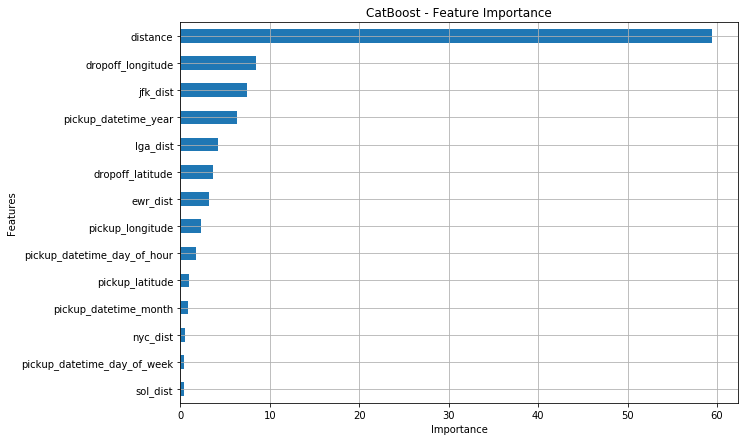

In [57]:
# 説明変数の重要度のグラフ化
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.grid()
plt.show()

In [58]:
y_pred = model.predict(test_pool)

In [59]:
Regression_evaluator(y_test, y_pred) # 関数呼び出し

平均絶対誤差： 1.6390055721774557
平均絶対誤差： 11.174502611850171
二乗平均平方根誤差： 3.3428285346170794
相関係数 (R)： 0.9363556691485009
決定係数 (R2)： 0.8767619391465369


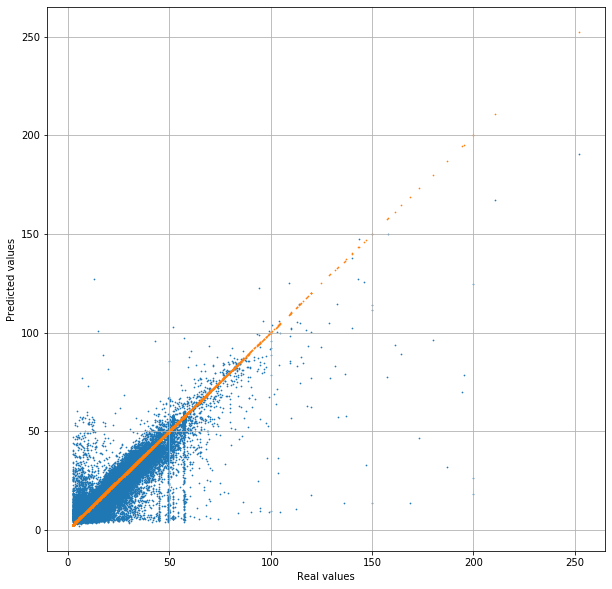

In [60]:
Draw_scatter(y_test, y_pred) # 関数呼び出し

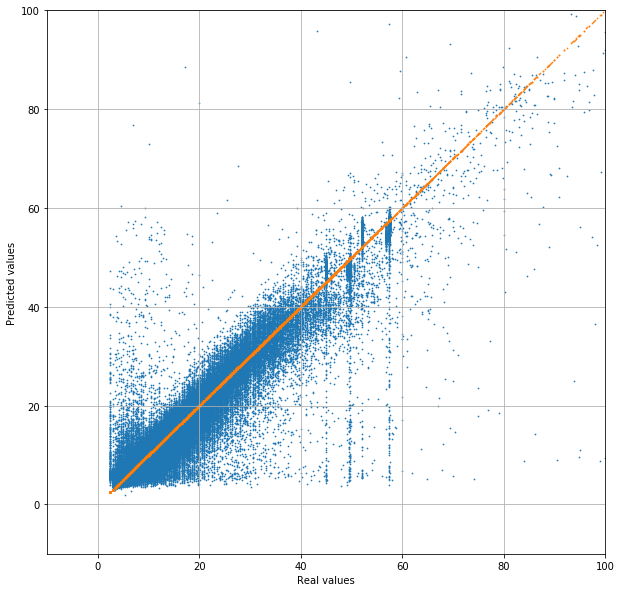

In [61]:
Draw_scatter2(y_test, y_pred) # 関数呼び出し

In [77]:
# Catboost(2) --> あっという間に終わった
# https://towardsdatascience.com/ad-demand-forecast-with-catboost-lightgbm-819e5073cd3e

from catboost import CatBoostRegressor

gc.collect()

train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')

model.fit(train_pool, eval_set=test_pool, plot=True)

gc.collect()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 8.8607619	test: 8.8630898	best: 8.8630898 (0)	total: 498ms	remaining: 24.4s
1:	learn: 8.2879965	test: 8.2861216	best: 8.2861216 (1)	total: 912ms	remaining: 21.9s
2:	learn: 7.7844148	test: 7.7794969	best: 7.7794969 (2)	total: 1.33s	remaining: 20.9s
3:	learn: 7.3465688	test: 7.3383862	best: 7.3383862 (3)	total: 1.72s	remaining: 19.8s
4:	learn: 6.9638095	test: 6.9519648	best: 6.9519648 (4)	total: 2.19s	remaining: 19.8s
5:	learn: 6.6332643	test: 6.6189697	best: 6.6189697 (5)	total: 2.68s	remaining: 19.7s
6:	learn: 6.3483328	test: 6.3303866	best: 6.3303866 (6)	total: 3.19s	remaining: 19.6s
7:	learn: 6.1002696	test: 6.0812344	best: 6.0812344 (7)	total: 3.65s	remaining: 19.1s
8:	learn: 5.8778725	test: 5.8555132	best: 5.8555132 (8)	total: 4.1s	remaining: 18.7s
9:	learn: 5.6847462	test: 5.6624891	best: 5.6624891 (9)	total: 4.51s	remaining: 18s
10:	learn: 5.5057041	test: 5.4827054	best: 5.4827054 (10)	total: 4.99s	remaining: 17.7s
11:	learn: 5.3438070	test: 5.3198079	best: 5.3198079 (1

0

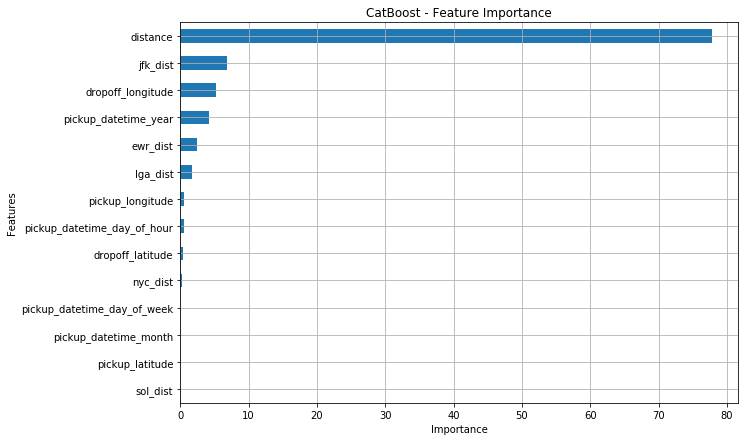

In [78]:
# 説明変数の重要度のグラフ化
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.grid()
plt.show()

In [79]:
y_pred = model.predict(test_pool)

In [80]:
Regression_evaluator(y_test, y_pred) # 関数呼び出し

平均絶対誤差： 2.056422849596023
平均絶対誤差： 15.601858737565749
二乗平均平方根誤差： 3.9499188267059044
相関係数 (R)： 0.9099092365823926
決定係数 (R2)： 0.8279348188179525


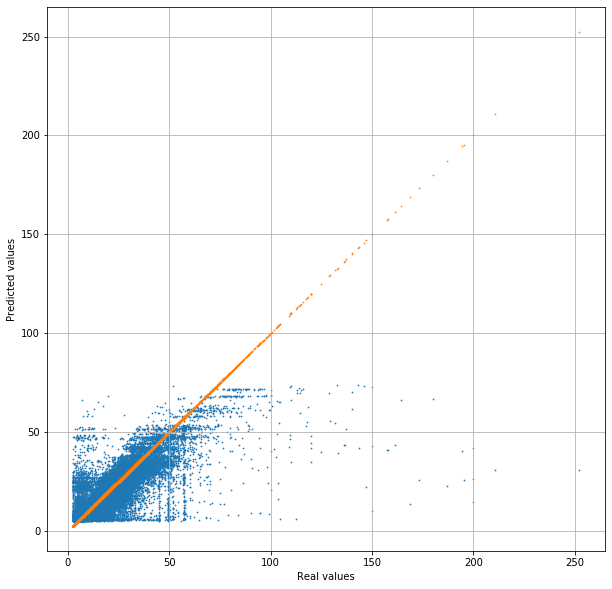

In [81]:
Draw_scatter(y_test, y_pred) # 関数呼び出し

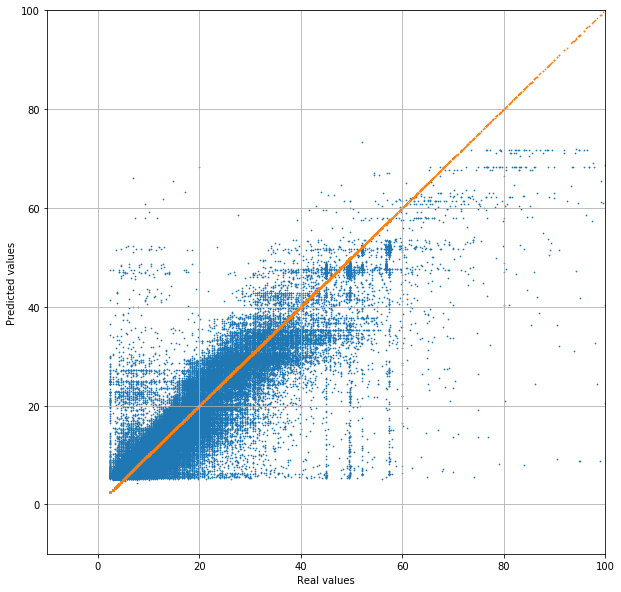

In [82]:
Draw_scatter2(y_test, y_pred) # 関数呼び出し

### 5-4. XGBoost

In [67]:
# XGBoost
# https://www.kaggle.com/gunbl4d3/xgboost-ing-taxi-fares

gc.collect() #gc.collect()は回収可能なオブジェクトを削除する

# Cross-validation
params = {
    # Parameters that we are going to tune.
    'max_depth': 8, # Result of tuning with CV
    'eta':.03, # Result of tuning with CV
    'subsample': 1, # Result of tuning with CV
    'colsample_bytree': 0.8, # Result of tuning with CV
    # Other parameters
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 1}

# Block of code used for hypertuning parameters. Adapt to each round of parameter tuning.
# Turn off CV in submission
CV=False
if CV:
    dtrain = xgb.DMatrix(train,label=y)
    gridsearch_params = [
        (eta)
        for eta in np.arange(.04, 0.12, .02)
    ]

    # Define initial best params and RMSE
    min_rmse = float("Inf")
    best_params = None
    for (eta) in gridsearch_params:
        print("CV with eta={} ".format(eta))

        # Update our parameters
        params['eta'] = eta

        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=1000,
            nfold=3,
            metrics={'rmse'},
            early_stopping_rounds=10
        )

        # Update best RMSE
        mean_rmse = cv_results['test-rmse-mean'].min()
        boost_rounds = cv_results['test-rmse-mean'].argmin()
        print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
        if mean_rmse < min_rmse:
            min_rmse = mean_rmse
            best_params = (eta)

    print("Best params: {}, RMSE: {}".format(best_params, min_rmse))
else:
    # Print final params to use for the model
    params['silent'] = 0 # Turn on output
    print(params)

{'max_depth': 8, 'eta': 0.03, 'subsample': 1, 'colsample_bytree': 0.8, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': 0}


In [68]:
def XGBmodel(X_train, X_test, y_train, y_test, params):
    matrix_train = xgb.DMatrix(X_train, label=y_train)
    matrix_test = xgb.DMatrix(X_test, label=y_test)
    model=xgb.train(params=params,
                    dtrain=matrix_train, num_boost_round=5000, 
                    early_stopping_rounds=10, evals=[(matrix_test,'test')])
    return model

model = XGBmodel(X_train, X_test, y_train, y_test,params)

gc.collect()

[09:02:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:02:33] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	test-rmse:14.0139
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:13.6242
[2]	test-rmse:13.2684
[3]	test-rmse:12.9029
[4]	test-rmse:12.5492
[5]	test-rmse:12.2096
[6]	test-rmse:11.8785
[7]	test-rmse:11.5762
[8]	test-rmse:11.286
[9]	test-rmse:10.9848
[10]	test-rmse:10.6936
[11]	test-rmse:10.4143
[12]	test-rmse:10.1567
[13]	test-rmse:9.89529
[14]	test-rmse:9.64197
[15]	test-rmse:9.39593
[16]	test-rmse:9.16092
[17]	test-rmse:8.94561
[18]	test-rmse:8.72355
[19]	test-rmse:8.50984
[20]	test-rmse:8.30531
[21]	test-rmse:8.1064
[22]	test-rmse:7.914
[23]	test-rmse:7.72966
[24]	test-rmse:7.55147
[25]	test-rmse:7.37942
[26]	test-rmse:7.22288
[27]	test-rmse:7.

[333]	test-rmse:3.28045
[334]	test-rmse:3.2802
[335]	test-rmse:3.27985
[336]	test-rmse:3.27964
[337]	test-rmse:3.279
[338]	test-rmse:3.27879
[339]	test-rmse:3.27874
[340]	test-rmse:3.27863
[341]	test-rmse:3.27839
[342]	test-rmse:3.27848
[343]	test-rmse:3.2782
[344]	test-rmse:3.27754
[345]	test-rmse:3.27738
[346]	test-rmse:3.27691
[347]	test-rmse:3.27667
[348]	test-rmse:3.27628
[349]	test-rmse:3.27591
[350]	test-rmse:3.27563
[351]	test-rmse:3.27551
[352]	test-rmse:3.27506
[353]	test-rmse:3.27472
[354]	test-rmse:3.27433
[355]	test-rmse:3.27412
[356]	test-rmse:3.27388
[357]	test-rmse:3.27367
[358]	test-rmse:3.27344
[359]	test-rmse:3.27297
[360]	test-rmse:3.27286
[361]	test-rmse:3.2726
[362]	test-rmse:3.27253
[363]	test-rmse:3.2725
[364]	test-rmse:3.27229
[365]	test-rmse:3.27215
[366]	test-rmse:3.27192
[367]	test-rmse:3.27167
[368]	test-rmse:3.27156
[369]	test-rmse:3.27113
[370]	test-rmse:3.27106
[371]	test-rmse:3.27078
[372]	test-rmse:3.2707
[373]	test-rmse:3.27005
[374]	test-rmse:3.26998

[676]	test-rmse:3.20898
[677]	test-rmse:3.20899
[678]	test-rmse:3.20898
[679]	test-rmse:3.20883
[680]	test-rmse:3.20882
[681]	test-rmse:3.20868
[682]	test-rmse:3.20851
[683]	test-rmse:3.20845
[684]	test-rmse:3.2083
[685]	test-rmse:3.20827
[686]	test-rmse:3.2082
[687]	test-rmse:3.20817
[688]	test-rmse:3.20815
[689]	test-rmse:3.20814
[690]	test-rmse:3.20805
[691]	test-rmse:3.20791
[692]	test-rmse:3.20788
[693]	test-rmse:3.20775
[694]	test-rmse:3.20775
[695]	test-rmse:3.20766
[696]	test-rmse:3.20766
[697]	test-rmse:3.20763
[698]	test-rmse:3.20757
[699]	test-rmse:3.20755
[700]	test-rmse:3.20735
[701]	test-rmse:3.20724
[702]	test-rmse:3.20721
[703]	test-rmse:3.20719
[704]	test-rmse:3.20718
[705]	test-rmse:3.20713
[706]	test-rmse:3.20695
[707]	test-rmse:3.20644
[708]	test-rmse:3.2064
[709]	test-rmse:3.20639
[710]	test-rmse:3.20611
[711]	test-rmse:3.20593
[712]	test-rmse:3.20587
[713]	test-rmse:3.20573
[714]	test-rmse:3.20572
[715]	test-rmse:3.20564
[716]	test-rmse:3.20556
[717]	test-rmse:3.2

65

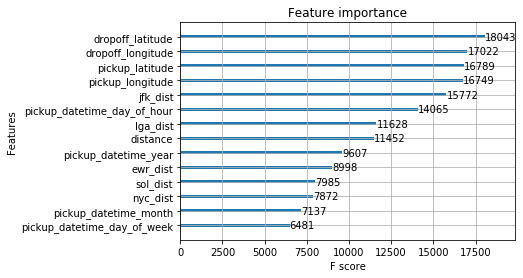

In [71]:
# 説明変数の重要度のグラフ化
xgb.plot_importance(model)

In [73]:
y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit = model.best_ntree_limit)

In [74]:
Regression_evaluator(y_test, y_pred) # 関数呼び出し

平均絶対誤差： 1.5080731707381942
平均絶対誤差： 10.233907535536513
二乗平均平方根誤差： 3.1990479107910392
相関係数 (R)： 0.941878599870993
決定係数 (R2)： 0.8871352968949421


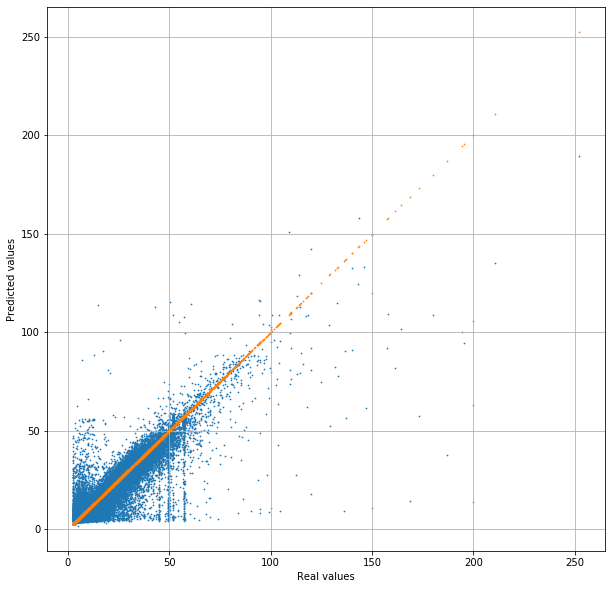

In [75]:
Draw_scatter(y_test, y_pred) # 関数呼び出し

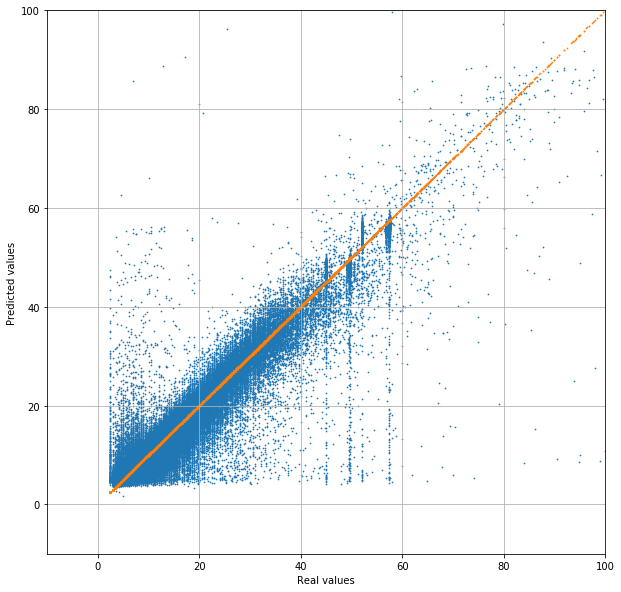

In [76]:
Draw_scatter2(y_test, y_pred) # 関数呼び出し

## 5-5. k-NN

In [83]:
# k-近傍法
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=3)

# モデルの学習
model = model.fit(X_train, y_train)

# テストデータ（検証データ）で予測
y_pred = model.predict(X_test)

In [84]:
Regression_evaluator(y_test, y_pred) # 関数呼び出し

平均絶対誤差： 1.9634076375511782
平均絶対誤差： 14.507492834749868
二乗平均平方根誤差： 3.8088702832664003
相関係数 (R)： 0.91651734240851
決定係数 (R2)： 0.8400040389355581


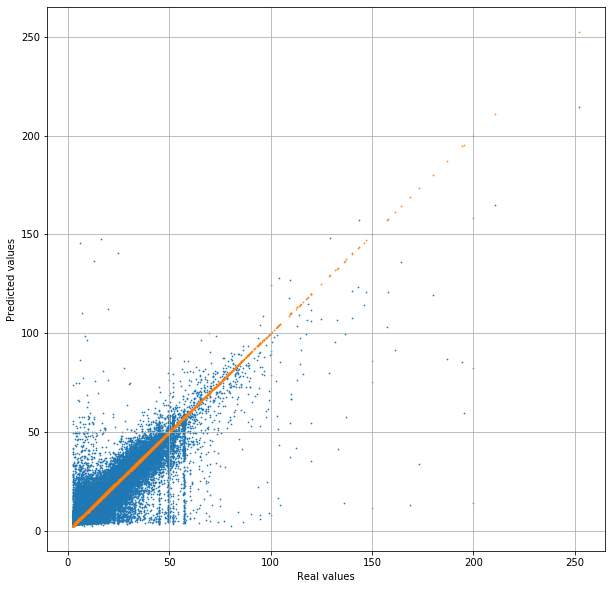

In [85]:
Draw_scatter(y_test, y_pred) # 関数呼び出し

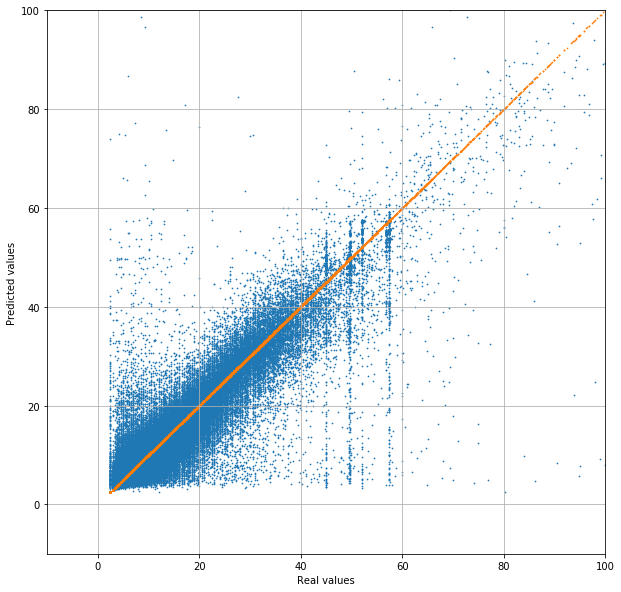

In [86]:
Draw_scatter2(y_test, y_pred) # 関数呼び出し